<a href="https://colab.research.google.com/github/ibanetz97/kpi_IDA2025/blob/main/lab2_IDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 4.54M/4.54M [00:00<00:00, 60.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/muratkokludataset/dry-bean-dataset/versions/1
Файли в датасеті: ['Dry_Bean_Dataset']
Dataset shape: (13611, 17)

Точність на початкових даних: 0.9207
Час навчання: 8.8771 c
Розмірність після PCA: 4

Точність після PCA: 0.8898
Час навчання після PCA: 5.0119 c

Порівняння результатів:
Зниження розмірності з 16 до 4 компонент
Початкова точність: 0.9207, після PCA: 0.8898
Час навчання: 8.8771 c → 5.0119 c

Виконується t-SNE, зачекайте...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


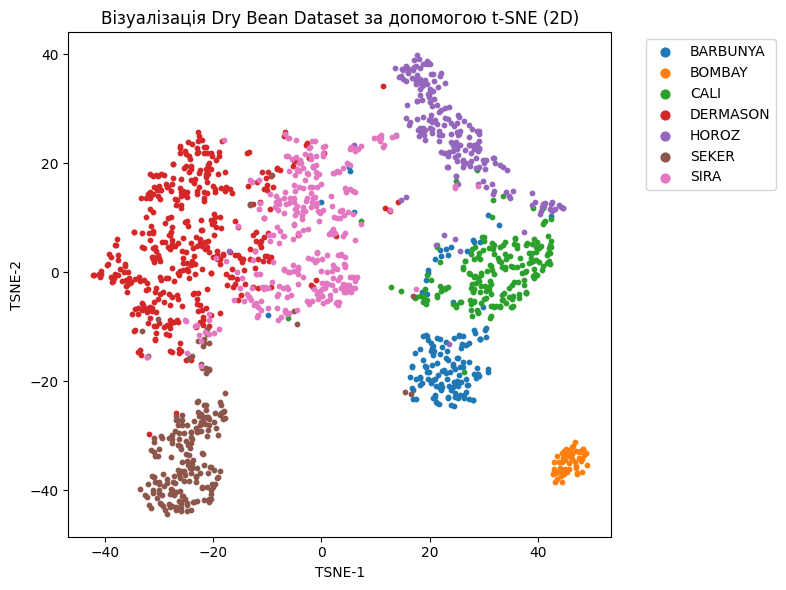

In [ ]:
import time
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Завантаження датасету
path = kagglehub.dataset_download("muratkokludataset/dry-bean-dataset")
print("Dataset downloaded to:", path)
print("Файли в датасеті:", os.listdir(path))
file_path = os.path.join(path, "Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx")
df = pd.read_excel(file_path)
# Використовується Dry Bean Dataset
#df = pd.read_excel('Dry_Bean_Dataset.xlsx')
print('Dataset shape:', df.shape)

# Визначення цільової змінної
y = df['Class']
X = df.drop(columns=['Class'])

# Кодування міток
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Масштабування ознак
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поділ на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# --- Класифікація на оригінальних даних ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
train_time_orig = end - start
pred_orig = rf.predict(X_test)
acc_orig = accuracy_score(y_test, pred_orig)

print(f"\nТочність на початкових даних: {acc_orig:.4f}")
print(f"Час навчання: {train_time_orig:.4f} c")

# --- PCA: збережемо 95% дисперсії ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('Розмірність після PCA:', X_pca.shape[1])

# Новий train/test
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# --- Класифікація після PCA ---
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
start = time.time()
rf_pca.fit(X_train_pca, y_train_pca)
end = time.time()
train_time_pca = end - start
pred_pca = rf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test_pca, pred_pca)

print(f"\nТочність після PCA: {acc_pca:.4f}")
print(f"Час навчання після PCA: {train_time_pca:.4f} c")

# --- Порівняння ---
print("\nПорівняння результатів:")
print(f"Зниження розмірності з {X.shape[1]} до {X_pca.shape[1]} компонент")
print(f"Початкова точність: {acc_orig:.4f}, після PCA: {acc_pca:.4f}")
print(f"Час навчання: {train_time_orig:.4f} c → {train_time_pca:.4f} c")

# --- t-SNE до 2D ---
print("\nВиконується t-SNE, зачекайте...")
subset_size = 1500 if len(X_scaled) > 1500 else len(X_scaled)
idx = np.random.choice(range(len(X_scaled)), subset_size, replace=False)
X_subset = X_scaled[idx]
y_subset = y_enc[idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca')
X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(8,6))
for i, label in enumerate(np.unique(y_subset)):
    plt.scatter(X_tsne[y_subset == label, 0], X_tsne[y_subset == label, 1], label=le.classes_[label], s=10)
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Візуалізація Dry Bean Dataset за допомогою t-SNE (2D)')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.savefig('tsne_dry_beans.png', dpi=200)
plt.show()




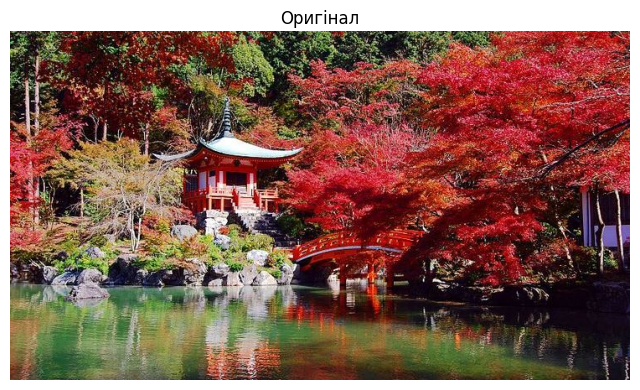

Квантування до 64 кольорів...


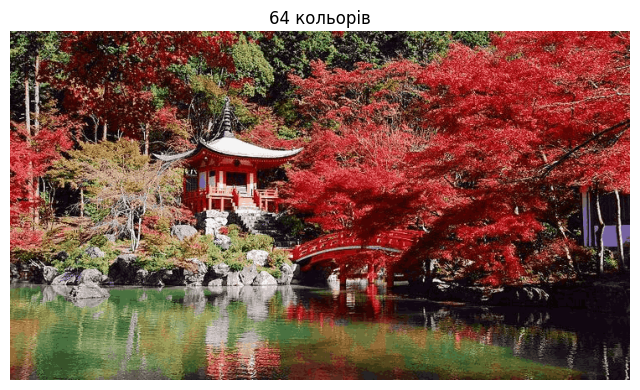

Квантування до 32 кольорів...


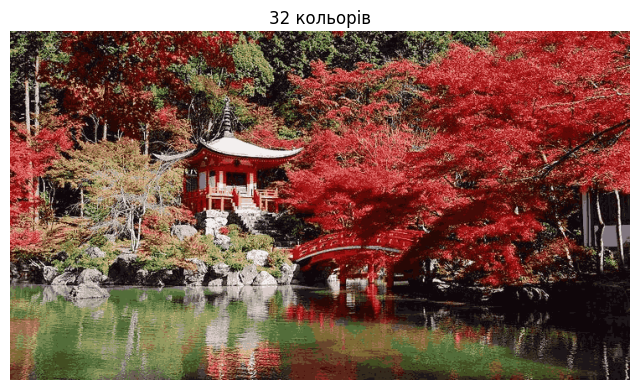

Квантування до 16 кольорів...


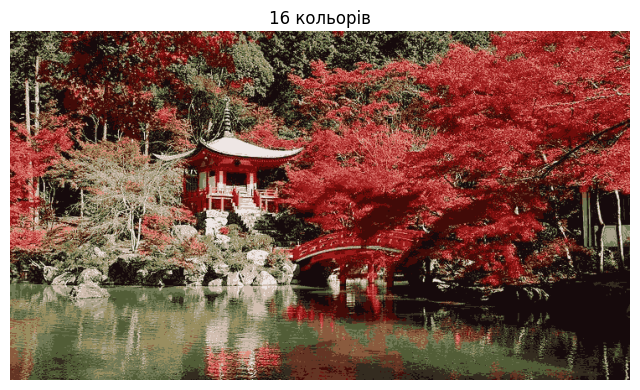

Квантування до 8 кольорів...


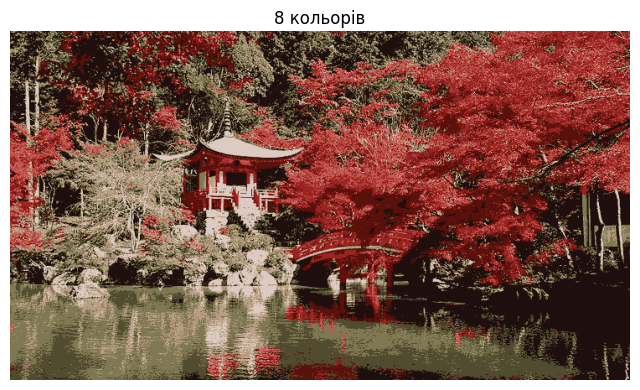

Квантування до 2 кольорів...


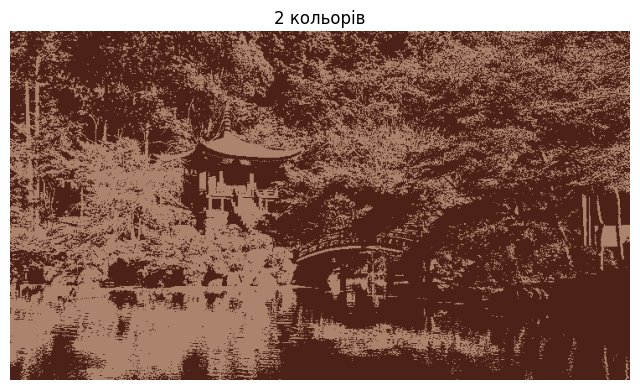

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from PIL import Image
import requests
from io import BytesIO

# Функція для завантаження та обробки зображення
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status() # Перевірка на помилки HTTP
        img = Image.open(BytesIO(response.content))
        img = img.convert("RGB") # Перетворення в RGB формат
        return np.array(img)
    except Exception as e:
        print(f"Помилка завантаження або обробки зображення: {e}")
        return None

# Функція для квантування зображення за допомогою k-means
def quantize_image(image, n_colors):
    # Перетворення пікселів у список
    pixels = image.reshape(-1, 3)

    # Застосування k-means
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    # Отримання центрів кластерів (нових кольорів)
    new_colors = kmeans.cluster_centers_.astype(int)

    # Заміна старих кольорів на нові
    new_pixels = new_colors[kmeans.labels_]

    # Перетворення назад у зображення
    quantized_image = new_pixels.reshape(image.shape)
    return quantized_image

# URL зображення для прикладу
image_url = "https://www.japan-guide.com/g18/740/3916_top.jpg"

# Завантаження зображення
image = load_image_from_url(image_url)

if image is not None:
    # Відображення оригінального зображення
    plt.figure(figsize=(8, 6))
    plt.title("Оригінал")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Кількість кольорів для квантування
    n_colors_list = [64, 32, 16, 8, 2]

    # Застосування квантування та відображення результатів
    for n_colors in n_colors_list:
        print(f"Квантування до {n_colors} кольорів...")
        quantized_img = quantize_image(image, n_colors)
        plt.figure(figsize=(8, 6))
        plt.title(f"{n_colors} кольорів")
        plt.imshow(quantized_img)
        plt.axis('off')
        plt.show()

else:
    print("Не вдалося завантажити або обробити зображення.")

In [1]:
import kagglehub
import os
import pandas as pd

# Download the dataset
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Dataset downloaded to:", path)

# List files in the downloaded directory to find the dataset file
print("Files in dataset directory:", os.listdir(path))



Using Colab cache for faster access to the 'amazonreviews' dataset.
Dataset downloaded to: /kaggle/input/amazonreviews
Files in dataset directory: ['test.ft.txt.bz2', 'train.ft.txt.bz2']


In [2]:
# Construct the full file path to the dataset file using the correct filename
file_name = "test.ft.txt.bz2"
file_path = os.path.join(path, file_name)

# Load the dataset into a pandas DataFrame, specifying the compression
# The files are tab-separated and have no header
df = pd.read_csv(file_path, compression='bz2', sep='\t', header=None, names=['label', 'review'])

# Display the first few rows and info of the DataFrame
display(df.head())
df.info()

label  review
0  __label__2 Great CD: My lovely Pat has one of ...     NaN
1  __label__2 One of the best game music soundtra...     NaN
2  __label__1 Batteries died within a year ...: I...     NaN
3  __label__2 works fine, but Maha Energy is bett...     NaN
4  __label__2 Great for the non-audiophile: Revie...     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   400000 non-null  object 
 1   review  0 non-null       float64
dtypes: float64(1), object(1)
memory usage: 6.1+ MB


In [3]:
# Load the dataset line by line and split each line, accessing the file object
data = []
with pd.io.common.get_handle(file_path, 'rt', compression='bz2', encoding='utf-8') as handles:
    # Access the underlying file object
    file_obj = handles.handle
    for line in file_obj:
        # Split only on the first space
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            data.append(parts)

# Create a DataFrame from the processed data
df = pd.DataFrame(data, columns=['label', 'review'])

# Display the first few rows and info of the DataFrame
display(df.head())
df.info()

label                                             review
0  __label__2  Great CD: My lovely Pat has one of the GREAT v...
1  __label__2  One of the best game music soundtracks - for a...
2  __label__1  Batteries died within a year ...: I bought thi...
3  __label__2  works fine, but Maha Energy is better: Check o...
4  __label__2  Great for the non-audiophile: Reviewed quite a...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   400000 non-null  object
 1   review  400000 non-null  object
dtypes: object(2)
memory usage: 6.1+ MB


In [4]:
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Ensure text is a string
    if not isinstance(text, str):
        return "" # Return empty string for non-string values

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the 'review' column after converting to string
df['cleaned_review'] = df['review'].astype(str).apply(preprocess_text)

# Display the first few rows with the new column
display(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


label                                             review  \
0  __label__2  Great CD: My lovely Pat has one of the GREAT v...   
1  __label__2  One of the best game music soundtracks - for a...   
2  __label__1  Batteries died within a year ...: I bought thi...   
3  __label__2  works fine, but Maha Energy is better: Check o...   
4  __label__2  Great for the non-audiophile: Reviewed quite a...   

                                      cleaned_review  
0  great cd lovely pat one great voices generatio...  
1  one best game music soundtracks game didnt rea...  
2  batteries died within year bought charger jul ...  
3  works fine maha energy better check maha energ...  
4  great nonaudiophile reviewed quite bit combo p...

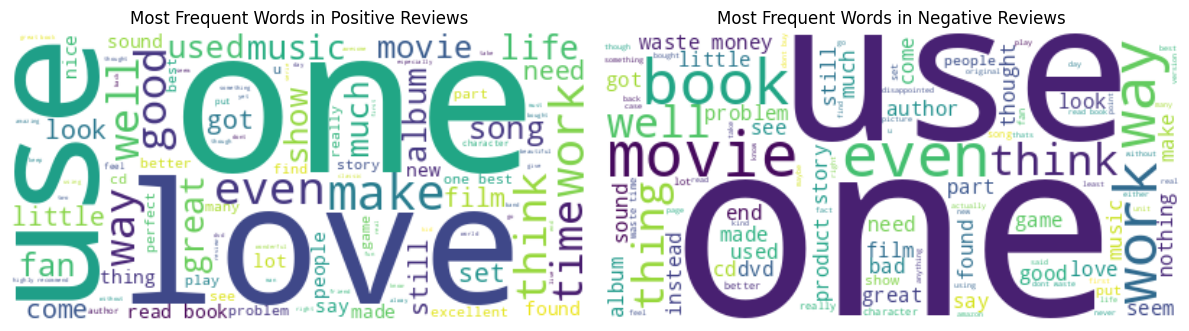

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data for positive and negative reviews
positive_reviews = df[df['label'] == '__label__2']['cleaned_review']
negative_reviews = df[df['label'] == '__label__1']['cleaned_review']

# Concatenate reviews into single strings
positive_text = ' '.join(positive_reviews.dropna())
negative_text = ' '.join(negative_reviews.dropna())

# Generate word cloud for positive reviews
wordcloud_positive = WordCloud(background_color='white', max_words=100, random_state=42).generate(positive_text)

# Generate word cloud for negative reviews
wordcloud_negative = WordCloud(background_color='white', max_words=100, random_state=42).generate(negative_text)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')

plt.tight_layout()
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'cleaned_review' column
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Print the shape of the resulting TF-IDF matrix
print("Shape of TF-IDF feature matrix:", X_tfidf.shape)

Shape of TF-IDF feature matrix: (400000, 492119)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Split data into training and testing sets
# Use the TF-IDF features (X_tfidf) and the original labels (df['label'])
# Stratify by label to ensure the same proportion of classes in both sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Train a Multinomial Naive Bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8435
Classification Report:
               precision    recall  f1-score   support

  __label__1       0.83      0.86      0.85     40000
  __label__2       0.86      0.82      0.84     40000

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000

